In [1]:
from alab_data import Sample, Material, Action, Measurement, Analysis, Ingredient, WholeIngredient, Actor, AnalysisMethod
import alab_data.views as views
from alab_data.utils.dev import drop_collections

In [2]:
drop_collections() #clear the whole database

# Defining Actors and AnalysisMethods 

These entries allow us to track which hardware, software, and operators are performing tasks within the experimental database.

`Actor`s perform synthesis `Action`s and `Measurements`. `AnalysisMethods` convert raw `Measurement`s into some useful metrics

Add or pull all Actor's from the ActorView

In [3]:
actorview = views.ActorView()

In [4]:
actorview.get_by_tags(["SolidStateALab"])


[]

In [5]:
labman = Actor(
    name="LabMan 30-105", 
    tags=["SolidStateALab"],
    description="A robotic system that weighs and mixes powders in crucibles. Used to prepare samples for firing in furnaces. This is in building 30-105 at Lawrence Berkeley National Laboratory.")

tubefurnace1 = Actor(
    name="TubeFurnace1 30-105", 
    tags=["SolidStateALab"],
    description="A tube furnace in building 30-105 at Lawrence Berkeley National Laboratory.")

aeris = Actor(
    name="Aeris 30-105",
    tags=["SolidStateALab"],
    description="An x-ray diffractometer. This is in building 30-105 at Lawrence Berkeley National Laboratory.")

operator = Actor(
    name="Operator",
    description = "A generic actor for any operation performed by a human. No need to name names!")
actorview.add(labman)
actorview.add(tubefurnace1)
actorview.add(aeris)
actorview.add(operator)

ObjectId('632a63e41330c6b33011bdc8')

In [6]:
actorview.get_by_tags(["SolidStateALab"])

[<Actor: LabMan 30-105>, <Actor: TubeFurnace1 30-105>, <Actor: Aeris 30-105>]

In [7]:
labman = actorview.get_by_name("LabMan 30-105")
labman

<Actor: LabMan 30-105>

Add or pull all analysis methods from AnalysisMethodView

In [8]:
analysismethodview = views.AnalysisMethodView()

In [9]:
cnn_phaseID = AnalysisMethod(
    name="CNN Phase ID", 
    tags=["SolidStateALab", "machinelearning"],
    description="A convolutional neural network trained to identify phases in x-ray diffraction patterns. doi: something/something")

analysismethodview.add(cnn_phaseID)

ObjectId('632a63e61330c6b33011bdcd')

# Entering experimental data into the database

First, we must define the individual nodes (`Action`, `Material`, `Measurement`, and `Analysis`) that will comprise the experimental steps and data for a given `Sample`

In [10]:
m0 = Material(
    name="Titanium Dioxide",
    formula="TiO2",
)

p0 = Action(    
    name="procurement",
    generated_materials=[m0],
    actor=operator,
)

In [11]:
p1 = Action(
    "grind",
    ingredients = [
        Ingredient(
            material=m0,
            amount=1,
            unit="g",
        )
    ],
    actor=operator,
    )
m1 = p1.make_generic_generated_material()

p2 = Action("sinter", ingredients = [WholeIngredient(m1)], actor=tubefurnace1)
m2 = p2.make_generic_generated_material()

p3 = Action("grind", ingredients = [WholeIngredient(m2)], actor=operator, final_step=True)
m3 = p3.make_generic_generated_material()

me0 = Measurement(
    name="XRD",
    material=m3,
    actor=aeris,
)

a0 = Analysis(
    name="Phase Identification",
    measurements=[me0],
    analysis_method=cnn_phaseID
)

Next, we will assign these nodes to a single `Sample`. This can be done manually in a few ways:

In [12]:
all_nodes = [p0, m0, p1, m1, p2, m2, p3, m3, me0, a0]

#if you have all nodes beforehand
s = Sample(name="first_sample", nodes=all_nodes)

#if you build nodes as you go. Maybe you want to build up the Sample object during the experiment?
s = Sample(name="first_sample_again")
for n in all_nodes:
    s.add_node(n)

We can check that the nodes within the Sample constitute a valid directed acyclic graph (DAG).

If this returns `False`, we didn't connect the nodes correctly.

In [13]:
s.has_valid_graph()

True

Up til now, the `Sample` object only lives in this notebook. Now we need to upload it into the database.

In [14]:
from alab_data.views.groups import SampleView
sv = SampleView()

`SampleView.add(sample)` does a few things. 

- First, it ensures that new nodes will not break the graph structures of the total database (at this point, ensures no dangling nodes)
- Second, it uploads the individual nodes into their respective collections
- Finally, it uploads the `Sample` entry to the sample collection, which maps the `Sample` to the individual nodes.

In [15]:
sv.add(s)

ObjectId('632a63e91330c6b33011bdd9')

We cannot add the same sample twice. If you have duplicate samples, you should rebuild a new `Sample` object instance.

In [16]:
sv.add(s)

ValueError: Sample (name=first_sample_again, id=632a63e91330c6b33011bdd9) already exists in the database!

## Shortcut to building `Sample`'s with a simple, linear process

As experimentalists, we often only know the initial `Material`'s and the sequence of synthesis `Action`'s. This is a simple linear graph, for which we have a shortcut method to skip the tedium of generating intermediate `Material`'s with which we do nothing.

Define your `Action`s as well as you can (_ie_ fill in the ingredients and generated_materials wherever possible). The rest will be filled in with generic, placeholder `Material`'s to stitch the `Action`'s into a valid graph.

In [17]:
# I know the starting material quite well, so I define it as usual.
m0 = Material(
    name="Titanium Dioxide",
    formula="TiO2",
)

p0 = Action(    
    name="procurement",
    generated_materials=[m0],
    actor=operator,
)

In [18]:
# I know what was done by which actors, but thats about it.
p1 = Action(
    "grind",
    actor=operator,
    )
p2 = Action("sinter", actor=tubefurnace1)
p3 = Action("grind", actor=operator, final_step=True)

In [19]:
# I also know that I measured the outputs of p3. I'll make a generic output material to link to the Measurement.

m_final = p3.make_generic_generated_material()

me0 = Measurement(
    name="XRD",
    material=m_final,
    actor=aeris,
)

a0 = Analysis(
    name="Phase Identification",
    measurements=[me0],
    analysis_method=cnn_phaseID
)

Now I can use the shortcut to build the linear `... Action -> Material -> Action ...` graph.

In [20]:
s = Sample(name="shortcut_sample")
s.add_linear_process(actions=[p0, p1, p2, p3])
s.add_node(me0)
s.add_node(a0)
s.has_valid_graph()

True

In [21]:
sv.add(s)

ObjectId('632a63f21330c6b33011bdfe')

# Adding extra fields to database entries

In the prior examples, only the required information has been provided to generate the experiment graph + add to the database. In real life, we want to attach metadata (process parameters, measured data, etc) to the graph nodes. This is pretty easy -- just pass them as additional keyword arguments when you define the nodes. Here is the same example, but with some metadata attached.

In [28]:
# I know the starting material quite well, so I define it as usual.
m0 = Material(
    name="Titanium Dioxide",
    formula="TiO2",
)

p0 = Action(    
    name="procurement",
    supplier="Alfa Aesar",
    CAS_number = "13463-67-7",
    price = "$100/gram",
    generated_materials=[m0],
    actor=operator,
)

In [29]:
# I know what was done by which actors, but thats about it.
p1 = Action(
    "grind",
    actor=operator,
    instrument="mortar and pestle",
    duration="1 hour",
    )
p2 = Action(
    "sinter", 
    actor=tubefurnace1, 
    temperature_celsius=1000,
    duration_hours = 4,
)
p3 = Action(
    "grind", 
    actor=operator, 
    final_step=True,
    instrument="mortar and pestle",
    duration="1 hour", #sounds like a rough day
    )

In [30]:
# I also know that I measured the outputs of p3. I'll make a generic output material to link to the Measurement.

m_final = p3.make_generic_generated_material()

me0 = Measurement(
    name="XRD",
    material=m_final,
    actor=aeris,
    settings = {
        "angle_min": 10,
        "angle_max": 80,
        "angle_step": 0.1,
        "exposure_time": 0.1,
    },
    data = {
        "x": [10, 20, 30, 40, 50, 60, 70, 80],
        "y": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    }
)

a0 = Analysis(
    name="Phase Identification",
    measurements=[me0],
    analysis_method=cnn_phaseID,
    results = [
        {"phase": "TiO2", "ICSD_coll": 1234, "fraction": 0.9},
        {"phase": "TiO", "ICSD_coll": 5678, "fraction": 0.1},
    ]
)

In [31]:
s = Sample(name="shortcut_sample")
s.add_linear_process(actions=[p0, p1, p2, p3])
s.add_node(me0)
s.add_node(a0)
s.has_valid_graph()

True

In [32]:
sv.add(s)

ObjectId('632a65741330c6b33011be10')

# Extras

For fun, you can plot the experimental graph for a given sample. Maybe this is qualitatively useful.

- Orange = Action
- Blue = Material
- Red = Measurement
- Green = Analysis

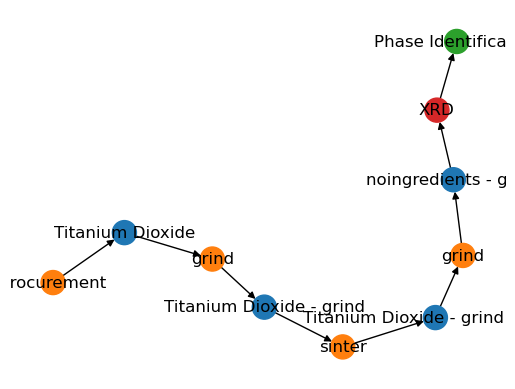

In [33]:
s.plot()